# Data Mining Lab 3 Pipeline Assignment

**Medium articles** are used to disseminate knowledge and are written on a wide range of technical and non-technical topics. Users subscribe to different reading lists where reading lists represent either domains or certain topics. This naturally gives rise to a network structure where articles may belong to the same reading lists and hence are related to each other. Each article belongs to a certain topic. Automatically assigning articles to topics is very valuable for search applications. **The goal of this task is to classify articles by predicting their topics.**

A dataset of medium articles along with subscription lists and topic tags is provided. The task is to classify articles into tags (i.e., topics), leveraging the network structure arising from relations using the subscription lists. Specifically, two nodes are connected if they share at least one list.

**For this task you may only use the following libraries**: `numpy`, `pandas`, `matplotlib`, `networkx`, `gensim`.


In [1]:
from collections import defaultdict
from itertools import combinations
from pathlib import Path

import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from gensim.models import Word2Vec, KeyedVectors

## Data loading

The data is provided in three files which can be found in the `data` directory:

- `articles.csv`: Contains the articles along with the subscription lists and some metadata.
- `test_data.csv`: Contains a subset of nodes (articles) along with their labels (topics) used for testing.
- `train_data.csv`: Contains the remaining nodes (articles) along with their labels (topics).

**Important**: There is no specific training data requried for this assignment, since the node embeddings (task 3) are trained on the entire graph. The nodes in `train_data.csv` must be used for the kNN classifier, i.e., the computed nearest neighbors for a test node may only be nodes from this file.

Let's use `pandas` to read these files:


In [2]:
articles = pd.read_csv(Path("data") / "articles.csv")
articles["node_id"] = articles.index
articles["lists"] = articles["lists"].str.split("; ")
test_data = pd.read_csv(Path("data") / "test_data.csv")
train_data = pd.read_csv(Path("data") / "train_data.csv")

Note that we have assigned node IDs based on where each article is located in the file.

We can now inspect the individual data frames:


In [4]:
articles.head(2)

,article,title,subtitle,author,date,lists,node_id
0,https://medium.com/@maniakacademy/code-demo-sh...,Code/Demo Share: Palo Alto Firewall Network In...,IP is broken as a unit of Control! IDENTITY as...,Sebastian Maniak,2022-08-17,[https://medium.com/@zemmali1990/list/aws-49f6...,0
1,https://medium.com/towards-artificial-intellig...,Clustering using Social Graph Network,A Social Graph Network can be formed when ther...,Naveed Ahmed Janvekar,2022-01-29,[https://medium.com/@TomaszCieplak/list/graph-...,1


In [5]:
test_data.head(2)

,node_id,label
0,2291,artificial-intelligence
1,7292,artificial-intelligence


Next, let's create our graph. We'll create one node for each article and insert an edge between two articles if they share at least one subscription list:


In [3]:
medium_graph = nx.Graph()
medium_graph.add_nodes_from(articles["node_id"].to_list())

list_to_nodes = defaultdict(set)
for _, row in articles[["node_id", "lists"]].iterrows():
    for l in row["lists"]:
        list_to_nodes[l].add(row["node_id"])

for node_ids in list_to_nodes.values():
    medium_graph.add_edges_from(combinations(node_ids, 2))

## Tasks

1. Familiarization: Analyze the graph. Compute and plot statistics such as the number of nodes, number of edges, number of neighbors of each node, and so on. Are there any isolated nodes (i.e., nodes that do not have a single neighbor)?
2. Compute spectral node embeddings.
3. Perform random walks on the graph to obtain a set of sequences of nodes. Use those sequences to compute node embeddings. Hint: You may use the Word2vec implementation of the gensim library for this task. By treating each node as a word, this method will give you node embeddings.
4. Implement a simple k-nearest neighbor classifier: For each node (medium article) in the test set, compute its nearest neighbors (based on the similarity of node embeddings). The classifier assigns a label (i.e., a topic) based on the topics of the nearest neighbors. Specifically, the predicted topic is simply the most common topic among the nearest neighbors. Compare both sets of node embeddings in terms of performance. Which one works better?


### Q1

The stats we show are the ones mentioned in the question

Number of nodes: 27718
Number of edges: 2014162
Node 0 has 144 neighbors
Node 1 has 102 neighbors
Node 2 has 18 neighbors
Node 3 has 34 neighbors
Node 4 has 15 neighbors
Node 5 has 8 neighbors
Node 6 has 317 neighbors
Node 7 has 154 neighbors
Node 8 has 198 neighbors
Node 9 has 37 neighbors
There are 347 isolated nodes


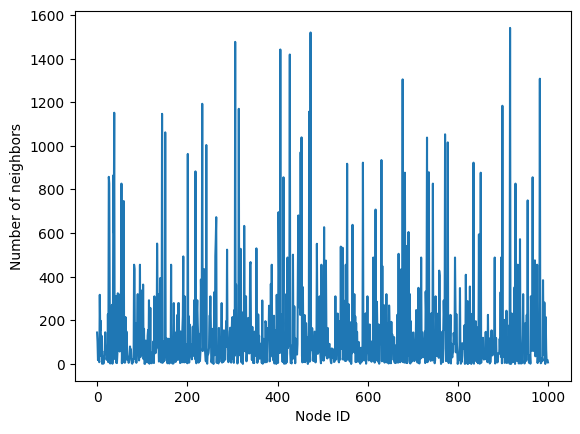

In [4]:
num_nodes = medium_graph.number_of_nodes()
print("Number of nodes:", num_nodes)
num_edges = medium_graph.number_of_edges()
print("Number of edges:", num_edges)

# Then we also print the degrees of several nodes
print_lim = 10
isolated = 0
for n in medium_graph.nodes:
    deg = medium_graph.degree(n)
    if print_lim > 0:
        print(f"Node {n} has {deg} neighbors")
        print_lim -= 1
    if deg == 0:
        isolated += 1
print(f"There are {isolated} isolated nodes")
some_nodes = list(medium_graph.nodes)[:1000]
plt.xlabel("Node ID")
plt.ylabel("Number of neighbors")
plt.plot(some_nodes, [medium_graph.degree[i] for i in some_nodes])
plt.show()

We can see that the nodes have neighbors within the tens and sometimes hundreds, up to over 1000.

Set the following to true if you want your embeddings to be written to files from now on.

In [5]:
write = False

### Q2

This is the weblab function, modified to return the full eigenvalue and eigenvector matrices.

## WARNING

The function takes 30 minutes to run, and the file will be 6 GB. If you have a .npy file of your own, copy it into this folder and name it 'spectral.npy'.

In [6]:
def compute_spectral_embeddings(graph: nx.Graph) -> (np.ndarray, np.ndarray):
    """Perform spectral clustering on the graph and compute low-dimensional node representations.
    Does not normalize the Laplacian.

    Args:
        graph (nx.Graph): The graph.
        dim (int): The dimension of representations. This corresponds to the number of eigenvectors used.

    Returns:
        np.ndarray: Node representations (sorted by node ID, ascending), shape (num_nodes, dim).
    """
    adjacency_matrix = nx.to_numpy_array(graph, nodelist=sorted(graph.nodes))

    # make sure the matrix is symmetric
    assert (adjacency_matrix == adjacency_matrix.T).all()

    L = np.zeros(adjacency_matrix.shape)
    for i in range(adjacency_matrix.shape[0]):
        L[i][i] = np.sum(adjacency_matrix[i])
    L -= adjacency_matrix
    return np.linalg.eigh(L)

In [7]:
if Path('spectral.npy').exists():
    evecs = np.load('spectral.npy')
    evals = np.load('evals.npy') if Path('evals.npy').exists() else np.zeros(num_nodes)
else:
    evals, evecs = compute_spectral_embeddings(medium_graph)
    if write:
        np.save('evals.npy', evals)
        np.save('spectral.npy', evecs)

In [8]:
for i in range(num_nodes):
    print(evals[i])
    if evals[i] > 0.0001:
        print(i)
        break

-3.5385831225479083e-13
-2.789545830835369e-13
-1.7547113148204025e-13
-1.3590469733146422e-13
-1.2825538953265882e-13
-1.264302603641249e-13
-9.70453096674734e-14
-9.58655018988909e-14
-7.934454110260438e-14
-7.1910896673531e-14
-6.909975803165802e-14
-6.849072212435846e-14
-6.784816975907437e-14
-6.596345711643151e-14
-6.393573342701642e-14
-6.157564164642408e-14
-6.114520788757878e-14
-6.035079524902047e-14
-5.913670303772837e-14
-5.857793313713905e-14
-5.697971308724844e-14
-5.3565205237217635e-14
-5.130956889609686e-14
-4.937320875416944e-14
-4.82991674299196e-14
-4.8131667348490124e-14
-4.8068000958922653e-14
-4.8003649671630965e-14
-4.577808752338383e-14
-4.4296800543950505e-14
-4.215943899365568e-14
-3.9590749706102936e-14
-3.8532696261413075e-14
-3.7746500296251073e-14
-3.697015526162162e-14
-3.525759701474446e-14
-3.3672081494914155e-14
-3.256250709136365e-14
-3.196786671350821e-14
-3.1954804918988515e-14
-3.184092518322834e-14
-2.9508842926029155e-14
-2.905379499672767e-14
-

We see that the first nonzero eigenvalue is the 760th. We can discard everything before.

We use 100 dimensions at first. We will adjust it later.

In [44]:
offset = 760
dim = 100
spectral_embed = evecs[:, offset:offset + dim]
spectral_embed

array([[-7.81740063e-17, -2.38235027e-18, -1.05480674e-20, ...,
         1.43261321e-04, -1.01111639e-04, -7.59469670e-05],
       [-2.19636903e-16, -8.84238567e-17, -9.25257073e-17, ...,
         4.40068681e-05,  2.50959317e-05, -8.41107868e-07],
       [ 7.33771574e-16, -3.69481427e-16, -3.85091177e-16, ...,
         4.36650881e-05, -1.17554483e-05,  6.59502211e-06],
       ...,
       [ 1.36351976e-16, -7.23927098e-16, -1.48446746e-16, ...,
         3.65317028e-05, -1.13768550e-05,  2.53415930e-08],
       [ 4.23651999e-17,  4.24457733e-17, -2.95813429e-16, ...,
         2.05273219e-04, -1.66534886e-04, -1.20926875e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.00901766e-20, -1.14914961e-21, -5.93864333e-21]])

If you need to free up space

In [ ]:
del evals, evecs

### Q3

This function is what we have on weblab, except we had to handle isolated nodes. We do that by making them walk back to themselves. This way, they are entirely similar to themselves, and others are not similar to them at all.

In [10]:
def random_walks(graph: nx.Graph, num_walks: int, walk_length: int) -> np.ndarray:
    """Perform random walks on an unweighted graph.

    Args:
        graph (nx.Graph): The graph.
        num_walks (int): The number of random walks for each node.
        walk_length (int): The number of nodes in a random walk.

    Returns:
        np.ndarray: The random walks, shape (n_nodes * num_walks, walk_length)
    """
    result = np.zeros((num_nodes * num_walks, walk_length), dtype=int)

    i = 0
    for idx, node in enumerate(graph.nodes):
        for walk in range(num_walks):
            here = node
            for j in range(walk_length):
                result[i, j] = here
                if not nx.is_isolate(graph, here):
                    here = np.random.choice(graph[here])
            i+=1

    return result

At first, we set the number of walks per node to 20 and the length to 5. The length being short probably helps in this context, the reasoning being that if we go too far along the links to other articles, it makes less sense to expect them to be about similar topics.

In [14]:
num_walks = 20
walk_length = 5
random_walk_list = random_walks(medium_graph, num_walks, walk_length)
random_walk_list

array([[    0, 10977, 17622, 20019,  3389],
       [    0,  6367, 19693, 22988, 27003],
       [    0, 26267,  6820, 27583, 19798],
       ...,
       [27717,  8872,  9808, 23780, 24823],
       [27717,  8872, 21386,  8872, 10861],
       [27717, 10861, 24823, 23035, 21386]])

Utility function for extracting embeds out of a Word2Vec model.

In [11]:
def w2v_to_numpy(w2v: Word2Vec) -> np.ndarray:
    return np.array([w2v.wv[i] for i in range(num_nodes)])

We create a Word2Vec model using these random walks as sentences.

In [16]:
model = Word2Vec(sentences=random_walk_list.tolist(), min_count=num_walks)
random_walk_embed = w2v_to_numpy(model)

### Q4

First we convert the train and test sets into arrays that we can work with.

In [12]:
train_labels = np.empty(num_nodes, dtype=object)
for i in range(train_data.shape[0]):
    train_labels[train_data['node_id'][i]] = train_data['label'][i]
print(train_labels)

['software-development' 'artificial-intelligence'
 'artificial-intelligence' ... 'artificial-intelligence' None None]


In [13]:
test_labels = np.empty(num_nodes, dtype=object)
for i in range(test_data.shape[0]):
    test_labels[test_data['node_id'][i]] = test_data['label'][i]
print(test_labels)

[None None None ... None 'software-development' 'software-development']


For the similarity measure, we use (negative) Euclidean distance.

In [14]:
def similarity(node_a: int, node_b: int, embed: np.ndarray[float]) -> float:
    return -np.linalg.norm(embed[node_a] - embed[node_b])

Below we implement a k-NN classifier for random walk embeddings. This function takes a node, a list of known train labels for nodes, a prebuilt Word2Vec model, and a _k_ parameter. It returns the most common label among the given node's most similar _k_ nodes.

(This is mostly meant for experimenting and tuning parameters, and is probably not how they expect us to use the Word2Vec. The general purpose classifier is below.)

In [26]:
def k_nearest_neighbors_wv(node_id: int, train_data: np.ndarray[str], embed_wv: KeyedVectors, k: int) -> str:
    counts = {}
    max_count = 0
    label = None
    for i, _ in embed_wv.most_similar(node_id):
        if k == 0:
            break
        l = train_data[i]
        if l:
            c = counts.get(l, 0) + 1
            if c > max_count:
                max_count = c
                label = l
            counts[l] = c
            k -= 1
    return label

Below we implement a k-NN classifier for general purpose. It takes the node id, the train labels of all nodes, their embeddings (spectral or random walk) and the _k_ parameter. It returns the most common label among the closest _k_ neighbors within the embedding space.

In [16]:
import heapq

def k_nearest_neighbors(node_id: int, train_data: np.ndarray[str], embed: np.ndarray[float] | KeyedVectors, k: int) -> str:
    if type(embed) is KeyedVectors:
        return k_nearest_neighbors_wv(node_id, train_data, embed, k)
    dists: list[(float, int)] = []
    heapq.heapify(dists)
    for i in range(train_data.shape[0]):
        if i != node_id and train_data[i]:
            d = similarity(i, node_id, embed)
            if len(dists) < k:
                heapq.heappush(dists, (d, i))
            elif d > dists[0][0]:
                heapq.heapreplace(dists, (d, i))
    counts = {}
    max_count = 0
    label = None
    for _, i in dists:
        l = train_data[i]
        c = counts.get(l, 0) + 1
        if c > max_count:
            max_count = c
            label = l
        counts[l] = c
    return label

Below is a function that calculates prediction accuracy over a validation sample of nodes.

In [17]:
def accuracy(sample: np.ndarray[int], train_data: np.ndarray[str], embed: np.ndarray[float] | KeyedVectors, k: int) -> float:
    correct = 0
    for node_id in sample:
        if k_nearest_neighbors(node_id, train_data, embed, k) == train_data[node_id]:
            correct += 1
    return correct / sample.shape[0]

Setting up stuff used for training:

In [34]:
ok_nodes = np.where(train_labels)[0] # only take nodes which have train labels
validation_size = int(0.8 * ok_nodes.shape[0]) # percentage of train set that we use as validation set

We tune the _k_ parameter by taking several values and plotting the fraction of correct guesses for each.

For tuning parameters, we will use the backup classifier, the one that uses the Word2Vec functionality. It would be very slow otherwise.

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


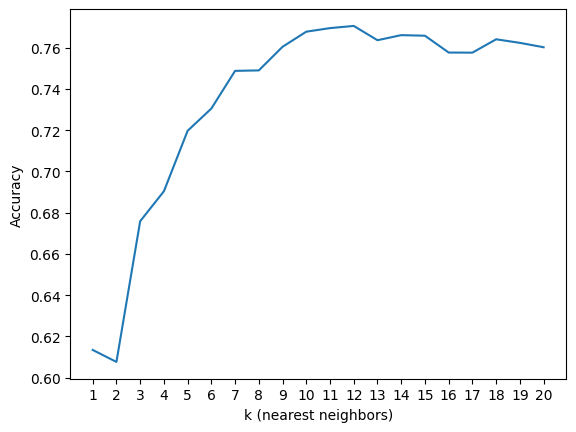

In [56]:
#chosen_embed = spectral_embed # too slow
chosen_embed = model.wv # backup
k_list = list(range(1, 21))
accuracies = []
for k in k_list:
    validation_nodes = np.random.choice(ok_nodes, size=validation_size)
    accuracies.append(accuracy(validation_nodes, train_labels, chosen_embed, k))
    print(k) # progress bar
plt.xticks(k_list)
plt.xlabel('k (nearest neighbors)')
plt.ylabel('Accuracy')
plt.plot(k_list, accuracies)
plt.show()

k = 12 seems to be a good choice.

We take the _k_ value of 12 and we use it to adjust the random walk parameters (adjusting all 3 parameters in parallel would probably be very slow). First, we make a big embedding matrix so that we can subsample it, instead of having to rerun the slow function everytime. We try out discrete, sparse values for the parameters, otherwise it would be too slow.

WARNING: random walks with large parameters can take long, results can be saved to file.

In [24]:
random_walk_big = np.array([])
if Path('random_walks.npy').exists():
    random_walk_big = np.load('random_walks.npy')
else:
    random_walk_big = random_walks(medium_graph, num_walks=48, walk_length=15)
    if write:
        np.save('random_walks.npy', random_walk_big)

WARNING: 8 minutes

2 walks, length 2
2 walks, length 3
2 walks, length 5
2 walks, length 10
2 walks, length 15
4 walks, length 2
4 walks, length 3
4 walks, length 5
4 walks, length 10
4 walks, length 15
8 walks, length 2
8 walks, length 3
8 walks, length 5
8 walks, length 10
8 walks, length 15
12 walks, length 2
12 walks, length 3
12 walks, length 5
12 walks, length 10
12 walks, length 15
16 walks, length 2
16 walks, length 3
16 walks, length 5
16 walks, length 10
16 walks, length 15
24 walks, length 2
24 walks, length 3
24 walks, length 5
24 walks, length 10
24 walks, length 15
48 walks, length 2
48 walks, length 3
48 walks, length 5
48 walks, length 10
48 walks, length 15


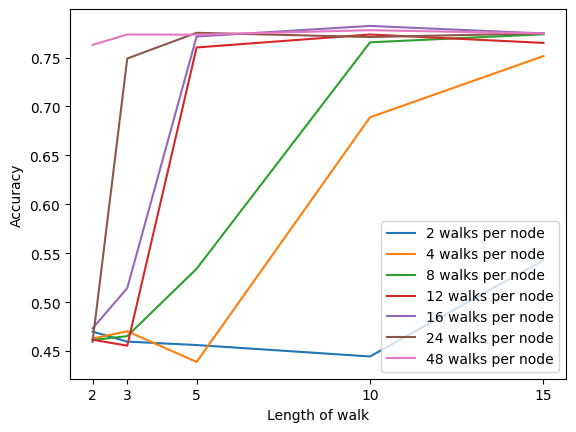

Maximum accuracy 0.7823512985199665 for 16 walks per node and 10 walk length


In [60]:
w_lengths = [2, 3, 5, 10, 15]
m_acc = 0
m_w_length = 2
m_n_walks = 2

plt.xlabel('Length of walk')
plt.ylabel('Accuracy')
plt.xticks(w_lengths)
for n_walks in 2, 4, 8, 12, 16, 24, 48:
    accs = []
    for w_length in w_lengths:
        print(f'{n_walks} walks, length {w_length}') # progress bar
        model_training = Word2Vec(sentences=random_walk_big[::48 // n_walks, :w_length].tolist(), min_count=n_walks)
        sample = np.random.choice(ok_nodes, size = validation_size)
        acc = accuracy(sample, train_labels, model_training.wv, k=12)
        accs.append(acc)
        if acc > m_acc:
            m_acc = acc
            m_w_length = w_length
            m_n_walks = n_walks
    plt.plot(w_lengths, accs, label=f'{n_walks} walks per node')
plt.legend()
plt.show()
print(f'Maximum accuracy {m_acc} for {m_n_walks} walks per node and {m_w_length} walk length')

Not great differences, but it seems that a good choice would be 24 walks and 5 walk length (good accuracy, not too many walks, diminishing returns if we go bigger)

Setting up the random walk with the obtained params.

In [22]:
n_walks_final = 24
w_length_final = 5
random_walk_final = random_walks(medium_graph, num_walks=n_walks_final, walk_length=w_length_final)
model_final = Word2Vec(sentences=random_walk_final.tolist(), min_count=n_walks_final)
random_walk_final_embed = w2v_to_numpy(model_final)
random_walk_final_embed

array([[-0.3277857 , -0.10145341, -0.02422459, ...,  0.18575874,
         0.34088346, -0.3311071 ],
       [-0.31381685,  0.2929329 ,  0.396703  , ..., -0.18407007,
        -0.01856453, -0.09176124],
       [-0.11523858,  0.10497209,  0.28489774, ..., -0.0935913 ,
        -0.09350957, -0.0920872 ],
       ...,
       [-0.12801813,  0.16499949,  0.17915563, ...,  0.0405668 ,
        -0.62037057,  0.13059102],
       [ 0.11795612,  0.01469144,  0.00086984, ...,  0.05534152,
         0.32809904, -0.13435392],
       [ 0.09899537,  0.48988554,  0.53224736, ...,  0.22081864,
         0.01099846, -0.5971477 ]], dtype=float32)

We can do similar training for the dimension parameter of spectral embedding. The KeyedVectors can be used to speed this up too.

In [42]:
spectral_big = evecs[:, offset:offset + 256]

32 dimensions


C:\Program Files\Python312\Lib\site-packages\gensim\models\keyedvectors.py:849: RuntimeWarning: divide by zero encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
C:\Program Files\Python312\Lib\site-packages\gensim\models\keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
C:\Program Files\Python312\Lib\site-packages\gensim\models\keyedvectors.py:449: RuntimeWarning: invalid value encountered in divide
  result = self.vectors[index] / self.norms[index]
C:\Program Files\Python312\Lib\site-packages\gensim\models\keyedvectors.py:449: RuntimeWarning: divide by zero encountered in divide
  result = self.vectors[index] / self.norms[index]


64 dimensions
100 dimensions
128 dimensions
200 dimensions
256 dimensions


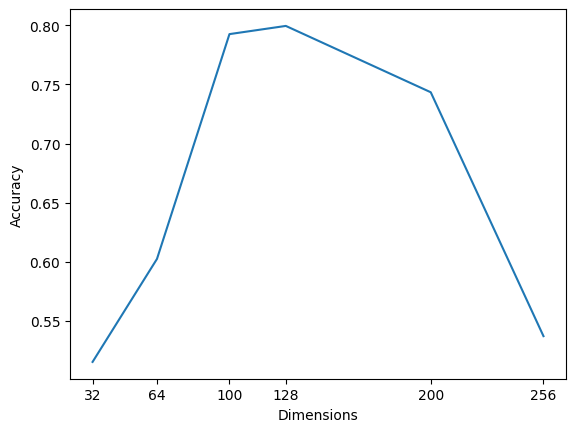

In [45]:
dims = [32, 64, 100, 128, 200, 256]
accs = []
for d in dims:
    print(f'{d} dimensions')
    #accs.append(accuracy(sample, train_labels, spectral_big[:, :d], k=12)) # too slow
    spectral_wv = KeyedVectors(d)
    spectral_wv.add_vectors(range(num_nodes), spectral_big[:, :d])
    sample = np.random.choice(ok_nodes, size = validation_size)
    accs.append(accuracy(sample, train_labels, spectral_wv, k=12)) # backup
plt.plot(dims, accs)
plt.xticks(dims)
plt.xlabel('Dimensions')
plt.ylabel('Accuracy')
plt.show()

128 seems to be a good parameter here.

In [46]:
dim_final = 128
spectral_embed_final = evecs[:, offset:offset + dim_final]
spectral_embed_final

array([[-7.81740063e-17, -2.38235027e-18, -1.05480674e-20, ...,
        -2.18233529e-04,  1.12421754e-04,  6.02759168e-05],
       [-2.19636903e-16, -8.84238567e-17, -9.25257073e-17, ...,
        -2.05406488e-05, -2.03409682e-04,  6.99743064e-05],
       [ 7.33771574e-16, -3.69481427e-16, -3.85091177e-16, ...,
        -2.67573986e-05, -2.38007148e-04,  7.89418901e-05],
       ...,
       [ 1.36351976e-16, -7.23927098e-16, -1.48446746e-16, ...,
        -2.03481058e-05, -2.10326032e-04,  8.29121019e-05],
       [ 4.23651999e-17,  4.24457733e-17, -2.95813429e-16, ...,
        -1.84399993e-04,  6.42096029e-05,  8.65599302e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         6.31174651e-17,  1.58414124e-16, -2.34351949e-16]])

Evaluating accuracy on the test set

In [19]:
def test_accuracy(embed: np.ndarray[float] | KeyedVectors, k: int = 12) -> float:
    correct = 0
    total = 0
    for i, label in enumerate(test_labels):
        if i % 100 == 0:
            print(i) # progress bar
        if label:
            total += 1
            guessed_label = k_nearest_neighbors(i, train_labels, embed, k)
            if guessed_label == label:
                correct += 1
    return correct / total

WARNING: for an embed length of 100 it takes up to 5 minutes (if slower, you can restart the kernel to clear memory, then only run the cells that are needed, i.e. not the ones about training)

In [20]:
print(test_accuracy(spectral_embed))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [25]:
print(test_accuracy(random_walk_final_embed))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

\>75%, good enough

These last tests are just for fun

In [48]:
spectral_wv = KeyedVectors(dim_final)
spectral_wv.add_vectors(range(num_nodes), spectral_embed_final)
print(test_accuracy(spectral_wv))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


C:\Program Files\Python312\Lib\site-packages\gensim\models\keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700


C:\Program Files\Python312\Lib\site-packages\gensim\models\keyedvectors.py:449: RuntimeWarning: invalid value encountered in divide
  result = self.vectors[index] / self.norms[index]


15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18600
18700
18800
18900
19000
19100
19200
19300
19400
19500
19600
19700
19800
19900
20000
20100
20200
20300
20400
20500
20600
20700
20800
20900
21000
21100
21200
21300
21400
21500
21600
21700
21800
21900
22000
22100
22200
22300
22400
22500
22600
22700
22800
22900
23000
23100
23200
23300
23400
23500
23600
23700
23800
23900
24000
24100
24200
24300
24400
24500
24600
24700
24800
24900
25000
25100
25200
25300
25400
25500
25600
25700
25800
25900
26000
26100
26200
26300
26400
26500
26600
26700
26800
26900
27000
27100
27200
27300
27400
27500
27600
27700
0.7934177215189874


In [27]:
print(test_accuracy(model_final.wv))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18